In [2]:
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet

import json

client = MalardClient()


In [3]:
#Discover the parent data sets available in this environment
pds = client.getParentDataSets()

print(pds)

['cryotempo', 'jatest', 'mtngla', 'mtnglauat', 'test', 'test_ja']


In [4]:
#Query the available data sets for a given parent
datasets = client.getDataSets('cryotempo')

for ds in datasets:
    print(str(ds))


parentDataSet=cryotempo, datSet=AntarcticaV2b, region=antarctic
parentDataSet=cryotempo, datSet=oib, region=greenland
parentDataSet=cryotempo, datSet=GRIS_BaselineC_Q2, region=greenland
parentDataSet=cryotempo, datSet=oib, region=antarctic
parentDataSet=cryotempo, datSet=AIS_BaselineC_FilteredPC, region=antarctic


In [5]:
#Get the bounding box for each data set
bounding_boxes = [client.boundingBox(ds) for ds in datasets]

for bb in bounding_boxes:
    print(str(bb))

minX=-2700000, maxX=2700000, minY=-2200000, maxY=2200000, minT=2017-01-01 00:53:20, maxT=2019-04-27 23:26:58 N=28313384600
minX=-2300000, maxX=900000, minY=-3400000, maxY=1400000, minT=2011-03-16 12:44:20, maxT=2016-09-15 15:18:30 N=66451574
minX=-700000, maxX=900000, minY=-3400000, maxY=-600000, minT=2011-02-01 05:16:06, maxT=2016-06-30 16:15:42 N=4986781805
minX=-2500000, maxX=1500000, minY=-2800000, maxY=2400000, minT=2011-10-12 14:51:34, maxT=2014-11-22 20:26:32 N=16720403
minX=-2700000, maxX=2700000, minY=-2200000, maxY=2200000, minT=2010-12-01 00:45:42, maxT=2016-12-31 23:22:35 N=9540724423


In [6]:
#get the grid cells within a bounding box
parentDs = 'cryotempo'
ds = 'GRIS_BaselineC_Q2'
region = 'greenland'

dataset = DataSet(parentDs, ds, region )
bb = client.boundingBox(dataset)

gcs = client.gridCells( dataset, bb )

#print(gcs[1])

shards = client.shards(dataset, bb )

print(shards[0].shardName)

/data/snail1/scratch/v2/malard/points//GRIS_BaselineC_Q2/gridcell/y2011/m2/cell_NPS_-700000_-1400000/GridCell_1_1569971388.nc


In [7]:
#retrieve the data for the first grid cell

resultInfo = client.executeQuery( dataset, gcs[0] )

#Print the status of the request
print( resultInfo.status )

#create a dataframe from the results
df = resultInfo.to_df

#release the underlying server resources
client.releaseCacheHandle( resultInfo.resultFileName )

Success


['File deleted successfully [/data/puma1/scratch/v2/malard/export/cryotempo_GRIS_BaselineC_Q2_1203466074.nc]']

In [9]:
#executeQuery polygon. Uses the shapefile passed in to determine the extent of the bounding box.
#The projection of the shapefile needs to be consistent with the data that is passed in.
#if using lat/lon for the xCol and yCol use EPSG: 4326 and (x,y) the proj4 code from the data set
from datetime import datetime

shapeFile = "/data/puma1/scratch/mtngla/chucach/Chucach-polygon_XY.shp"

alaskaDataSet = DataSet( 'mtngla', 'ADwithTDX', 'alaska' ) 

minT = datetime(2011,1,1,0,0)
maxT = datetime(2011,2,1,0,0)

chucachDf = client.executeQueryPolygon( alaskaDataSet, minT, maxT, shapeFile=shapeFile ).to_df

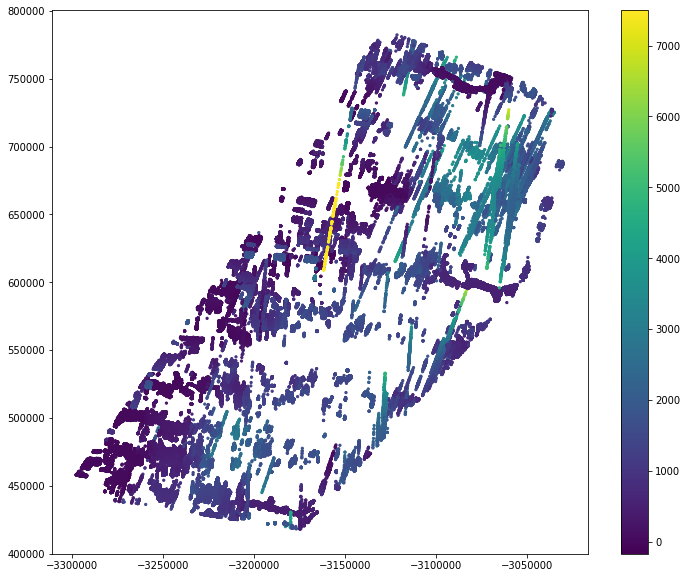

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

df = chucachDf
## plot with no filters
plt.figure(figsize=(12,10))
plt.scatter(x=df['x'], y=df['y'], c=df['elev'], marker='.', s=20, vmax=7500)
plt.colorbar()
plt.show()

In [ ]:
#get the input swath file names from the input dataframe

file_ids = df['swathFileId'].unique()

results = client.getSwathNamesFromIds( dataset, file_ids )
print(results)